In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import backend as keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, save_model, load_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
import os
from astroNN.nn.layers import MCDropout
import math


Reading JLA covariance matrix and examinate the min, max and mean from it. 

In [2]:
ffnn = tf.keras.models.load_model('../models/FFNN_JLA2.h5')
ffnn_do = tf.keras.models.load_model('..models/FFNN_JLA_DO.h5', custom_objects={'MCDropout': MCDropout})


syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
file = '../data/jla_binned_distances_31nodes_v1.txt'

# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
print(np.min(syscov), np.max(syscov), np.mean(syscov))
nsize = len(syscov)

# scaler_sys = StandardScaler()
# scaler_sys.fit(syscov)
# syscov_sc = scaler_sys.transform(syscov)
data = np.loadtxt(file, skiprows=3)
z_redshift = data[:, 0]
errors = np.diag(syscov).reshape(nsize,)
errors_logs = np.where(errors!= 0, np.log(errors), 0)

print(np.shape(data[:,1]), np.shape(errors), np.shape(syscov))


-0.01084098704 0.02815552265 0.00039265133851975654
(31,) (31,) (31, 31)


In [3]:
scalercov = StandardScaler()
scalercov.fit(syscov)
syscov_sc = scalercov.transform(syscov)

scalerdist = StandardScaler()
scalerdist.fit(data[:,1].reshape(-1,1))
dist_sc = scalerdist.transform(data[:,1].reshape(nsize,1))

scalererr = StandardScaler()
scalererr.fit(errors.reshape(-1,1))
errors_sc = scalerdist.transform(errors.reshape(nsize,1))

Text(0.5, 1.0, 'Original matrix scaled and extended')

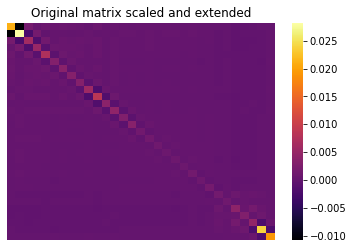

In [4]:
sns.heatmap(syscov, 
# sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title('Original matrix scaled and extended')

In [5]:
def permutMatrix(omatrix, nmatrix):
    nsize = len(omatrix)
    matrixset = np.zeros((nmatrix, nsize, nsize))
    for it in range(nmatrix):
        perm = np.random.permutation(nsize)
        P = np.eye(nsize)[perm]
        p = P@omatrix@P.T
        p = symmetrical(p)
        matrixset[it, :, :nsize] = p
        
    return matrixset


In [6]:
def symmetrical(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
    #         if np.iscomplex(syscov[i,j]):
    #             print("COMPLEX")
            if matrix[i,j] != matrix[j,i]:
                    if np.abs(matrix[i, j]) < np.abs(matrix[j,i]):
                        matrix[i, j] = matrix[j, i]
                    else:
                        matrix[j, i] = matrix[i, j]
            
    return matrix

In [7]:
def orderMag(number):
    if number == 0.0:
        return 0.0
    else:
        return math.floor(math.log(np.abs(number), 10))

def matrixMag(matrix):
    mshape = np.shape(matrix)
    magMatrix = np.zeros(mshape)
    for row in range(nsize):
        for col in range(nsize):
            magMatrix[row, col] = orderMag(matrix[row, col])
    return magMatrix            

In [8]:
numMatrix = 10000
covset = np.zeros((numMatrix, 31, 31))
permMatrix = permutMatrix(syscov_sc, numMatrix)
# magnitudes = matrixMag(ext_matrix)
print(np.shape(permMatrix))

(10000, 31, 31)


Text(0.5, 1.0, 'PERMUTATED MATRIX (SCALED)')

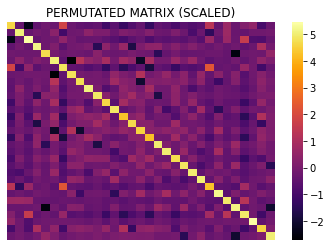

In [9]:
sns.heatmap(pd.DataFrame(permMatrix[0, :, :]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("PERMUTATED MATRIX (SCALED)")


Text(0.5, 1.0, 'PERMUTATED MATRIX')

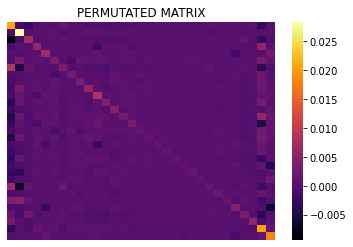

In [10]:
sns.heatmap(scalercov.inverse_transform(permMatrix[0, :, :]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("PERMUTATED MATRIX")

In [11]:
for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    for row in range(nsize):
        for col in range(nsize):
            err = np.random.randn()
            if row == col:
                covset[i, row, col] = permMatrix[i, row, col] + 1e-3*err*10**orderMag(permMatrix[i, row, col])
            else:
                covset[i, row, col] = permMatrix[i, row, col] + 1e-3*err*10**orderMag(permMatrix[i, row, col])


 Generating 10000 matrix                       

In [12]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
# covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)
# np.shape(covset_noise_test)

(10000, 31, 31)


Text(0.5, 1.0, 'TEST MATRIX')

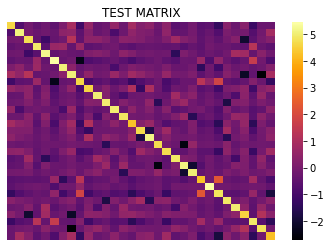

In [13]:
sns.heatmap(pd.DataFrame(covset_test[0,:,:]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("TEST MATRIX")

# Start design of ConVAE

In [14]:
# Sampling class from https://github.com/keras-team/keras-io

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [15]:
input_shape = (31, 31, 1)
latent_dim = 2


inputs = tf.keras.Input(shape=input_shape, name='encoder_input')
# ((top_pad, bottom_pad), (left_pad, right_pad))
x = layers.ZeroPadding2D(((5,4),(5,4)))(inputs)
x = layers.Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
shape_enc = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(100)(x)
x = layers.Dense(50)(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
# z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_sigma])
z = Sampling()([z_mean, z_log_var])

# z = layers.Lambda(sampling)([z_mean, z_log_sigma])
encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 31, 31, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 40, 40, 1)    0           encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 20, 20, 32)   320         zero_padding2d[0][0]             
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 10, 10, 32)   0           conv2d[0][0]                     
____________________________________________________________________________________________

In [16]:
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(shape_enc[1] * shape_enc[2] * shape_enc[3], activation='relu')(latent_inputs)
x = layers.Reshape((shape_enc[1], shape_enc[2], shape_enc[3]))(x)
x = layers.Dense(50)(x)
x = layers.Dense(100)(x)
x = layers.Conv2DTranspose(64, (3,3), activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(64, (3,3), activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, (3,3), activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(1, (3,3), activation='linear', strides=2, padding='same')(x)
# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
# x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
# x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
# x = layers.Conv2D(1, (5, 5), activation='linear', padding='same')(x)
outputs = layers.Cropping2D(cropping=((1, 0), (1, 0)))(x)

# Decoder model
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               768       
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 64)          0         
_________________________________________________________________
dense_5 (Dense)              (None, 2, 2, 50)          3250      
_________________________________________________________________
dense_6 (Dense)              (None, 2, 2, 100)         5100      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 64)          57664     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 64)          3692

In [17]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae_conv')
vae.summary()

Model: "vae_conv"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 31, 31, 1)]       0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 86698     
_________________________________________________________________
decoder (Functional)         (None, 31, 31, 1)         122463    
Total params: 209,161
Trainable params: 209,161
Non-trainable params: 0
_________________________________________________________________


In [18]:
# VAE class from https://github.com/keras-team/keras-io
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [19]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

covmatrixset = np.concatenate([covset_train, covset_train], axis=0)
covmatrixset = np.expand_dims(covmatrixset, -1).astype("float32")



### TRAINING

In [20]:
vae_train = vae.fit(covmatrixset, epochs=150, batch_size=128)            #500            

Epoch 1/150
125/125 [==============================] - 4s 24ms/step - loss: -1970.4146 - reconstruction_loss: -2782.5930 - kl_loss: 61.6702
Epoch 2/150
125/125 [==============================] - 3s 25ms/step - loss: -3444.9206 - reconstruction_loss: -3461.2175 - kl_loss: 11.7450
Epoch 3/150
125/125 [==============================] - 3s 25ms/step - loss: -3453.4080 - reconstruction_loss: -3461.2144 - kl_loss: 10.8161
Epoch 4/150
125/125 [==============================] - 3s 24ms/step - loss: -3450.7310 - reconstruction_loss: -3461.8320 - kl_loss: 6.5303
Epoch 5/150
125/125 [==============================] - 3s 23ms/step - loss: -3457.7408 - reconstruction_loss: -3461.6621 - kl_loss: 3.5375
Epoch 6/150
125/125 [==============================] - 3s 22ms/step - loss: -3458.6409 - reconstruction_loss: -3462.1348 - kl_loss: 6.6701
Epoch 7/150
125/125 [==============================] - 3s 22ms/step - loss: -3410.5520 - reconstruction_loss: -3461.1841 - kl_loss: 24.2305
Epoch 8/150
125/125 [==

125/125 [==============================] - 3s 24ms/step - loss: -3596.9735 - reconstruction_loss: -3596.9248 - kl_loss: 5.3561e-04
Epoch 59/150
125/125 [==============================] - 3s 22ms/step - loss: -3597.1153 - reconstruction_loss: -3596.9250 - kl_loss: 4.9951e-04
Epoch 60/150
125/125 [==============================] - 3s 21ms/step - loss: -3596.7289 - reconstruction_loss: -3596.9253 - kl_loss: 4.6818e-04
Epoch 61/150
125/125 [==============================] - 3s 22ms/step - loss: -3596.9372 - reconstruction_loss: -3596.9246 - kl_loss: 4.3904e-04
Epoch 62/150
125/125 [==============================] - 3s 22ms/step - loss: -3597.0377 - reconstruction_loss: -3596.9250 - kl_loss: 4.1001e-04
Epoch 63/150
125/125 [==============================] - 3s 24ms/step - loss: -3596.8711 - reconstruction_loss: -3596.9255 - kl_loss: 3.8460e-04
Epoch 64/150
125/125 [==============================] - 3s 23ms/step - loss: -3596.9033 - reconstruction_loss: -3596.9258 - kl_loss: 3.6287e-04
Epoch

125/125 [==============================] - 3s 27ms/step - loss: -3596.9541 - reconstruction_loss: -3596.9253 - kl_loss: 1.5616e-05
Epoch 115/150
125/125 [==============================] - 4s 28ms/step - loss: -3597.1732 - reconstruction_loss: -3596.9270 - kl_loss: 1.4571e-05
Epoch 116/150
125/125 [==============================] - 4s 28ms/step - loss: -3597.0564 - reconstruction_loss: -3596.9263 - kl_loss: 1.3635e-05
Epoch 117/150
125/125 [==============================] - 3s 28ms/step - loss: -3597.0872 - reconstruction_loss: -3596.9255 - kl_loss: 1.3031e-05
Epoch 118/150
125/125 [==============================] - 3s 28ms/step - loss: -3596.9413 - reconstruction_loss: -3596.9248 - kl_loss: 1.2066e-05
Epoch 119/150
125/125 [==============================] - 3s 28ms/step - loss: -3596.9355 - reconstruction_loss: -3596.9258 - kl_loss: 1.1383e-05
Epoch 120/150
125/125 [==============================] - 3s 28ms/step - loss: -3596.7594 - reconstruction_loss: -3596.9260 - kl_loss: 1.0217e-05

(array([-3800., -3600., -3400., -3200., -3000., -2800., -2600.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

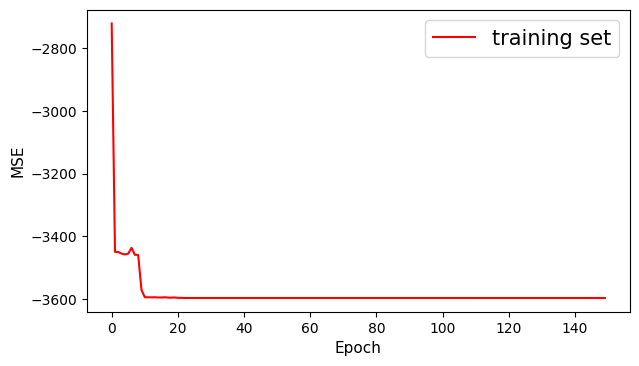

In [21]:
plt.figure(figsize=(7, 4), dpi=100)

plt.plot(vae_train.history['loss'], color='r', )

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set'], loc='upper right', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

(3, 2000, 2)


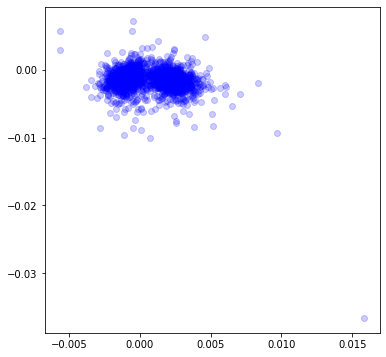

In [22]:
x_test_encoded = encoder.predict(covset_test)
print(np.shape(x_test_encoded))
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[ 0], x_test_encoded[1], marker='o', c='blue', alpha=0.2)
# plt.colorbar()
plt.show()

In [23]:
print(np.shape(x_test_encoded), type(x_test_encoded))
x_test_encoded[:][0][:]

(3, 2000, 2) <class 'list'>


array([[-0.00208259,  0.00191977],
       [-0.00174155,  0.00225261],
       [-0.00129993,  0.00176643],
       ...,
       [-0.00063094,  0.00334971],
       [-0.0013601 ,  0.00139516],
       [-0.00079182,  0.00275711]], dtype=float32)

## Generate synthetic covariance matrix

In [24]:
np.shape(syscov_sc), np.shape(covset_test), np.shape(covset_test[0])

((31, 31), (2000, 31, 31), (31, 31))

In [25]:
ztest1 = encoder.predict(covset_test[0].reshape((1,31,31)))
ztest1

[array([[-0.00208263,  0.00191981]], dtype=float32),
 array([[-0.00391978, -0.00455981]], dtype=float32),
 array([[-0.8944242,  2.0020194]], dtype=float32)]

(1, 31, 31, 1)


<AxesSubplot:>

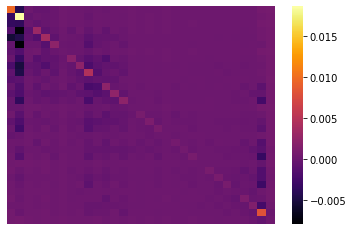

In [26]:
pred_matrix = decoder.predict(ztest1[1])
print(np.shape(pred_matrix))
pred_cov_sc = pred_matrix[0, :, :nsize, 0]
pred_cov = scalercov.inverse_transform(pred_cov_sc)

sns.heatmap(pd.DataFrame(pred_cov), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

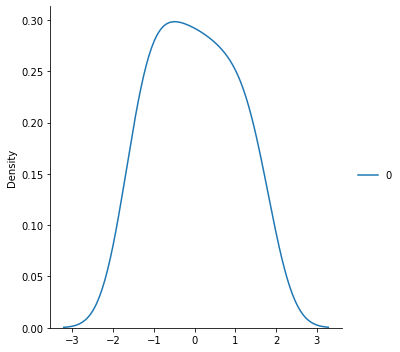

In [27]:
sns.displot(dist_sc, kind='kde')

In [65]:
# zmean = np.mean(dist_sc)
# zstd = np.std(dist_sc)
zmean = 0.0
zstd = 1.0
zmean, zstd

(0.0, 1.0)

In [66]:
z_sample = np.array([[zmean, zstd]])
pred_matrix = decoder.predict(z_sample)

<AxesSubplot:>

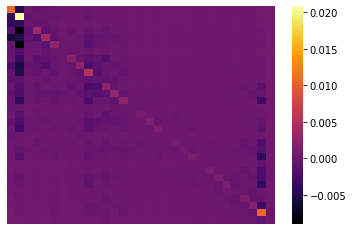

In [67]:
pred_cov_sc = pred_matrix[0, :, :nsize, 0]
pred_cov = scalercov.inverse_transform(pred_cov_sc)

sns.heatmap(pred_cov, 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [68]:
np.savetxt("fake_binned_JLA_COVdecodedTEST2vae.dat", pred_cov, delimiter= " ", header="#fake COV")

# Test with new data

In [32]:
ranz = z_redshift

index = np.argsort(ranz)

pred_random = ffnn.predict(np.log(ranz))
# pred_dl = scalerdl.inverse_transform(pred_random[:,0].reshape(-1,1))
pred_dl = pred_random[:,0][index].reshape(-1,1)
pred_err = np.exp(pred_random[:,1][index].reshape(-1,1))

fake_data = np.stack((ranz[index], pred_dl.reshape(31,)[index]), axis=1)

np.savetxt("fake_binned_JLA2TEST3.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')

In [72]:
pred_dl_sc = scalerdist.transform(pred_dl)
zmean_real = np.mean(dist_sc)
zstd_real = np.std(dist_sc)
print(zmean_real, zstd_real)
zmean_pred = np.mean(pred_dl_sc)
zstd_pred = np.std(pred_dl_sc)
print(zmean_pred, zstd_pred)

desv_real = zmean_real - zstd_real
new_mean = (zmean_pred - zmean_real)/desv_real
new_std = desv_real/(zmean_pred - zstd_pred)

new_mean, new_std

4.226010222766725e-16 1.0000000000000002
-0.024898464 1.0072505


(0.024898463860154582, 0.9688524054337267)

In [73]:
z_sample = np.array([[new_mean, new_std]])
newmatrix = decoder.predict(z_sample)

<AxesSubplot:>

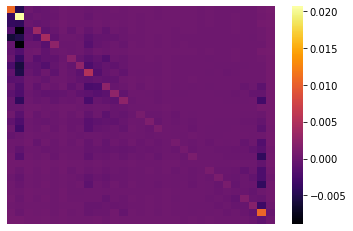

In [35]:
newmatrixr = scalercov.inverse_transform(newmatrix.reshape(31,31))
# # clean_imgr = clean_img[0,:,:,0].reshape(31,31)

sns.heatmap(pd.DataFrame(newmatrixr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [36]:
np.savetxt("fake_binned_JLA_COVdecodedTEST3vae.dat", newmatrixr, delimiter= " ", header="#fake COV")

In [37]:
# tf.keras.models.save_model(vae, '../models/convae.h5')
# tf.keras.models.save_model(encoder, '../models/convae_enc.h5')
# tf.keras.models.save_model(decoder, '../models/convae_dec.h5')

In [39]:
vae.save_weights('vae_weights', save_format='tf')

# loaded_model = ClassifierModel(parameter)
# loaded_model.compile(parameters)
# loaded_model.train_on_batch(x_train[:1], y_train[:1])
# loaded_model.load_weights('model_weights')